In [1]:
import os
import torch
import torchvision
import xml.etree.ElementTree as ET
from PIL import Image
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [2]:
class VOCDataset(Dataset):
    def __init__(self, img_dir, ann_dir, file_list, transforms=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transforms = transforms
        with open(file_list) as f:
            self.img_files = [line.strip() for line in f.readlines()]
        
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, f"{img_name}.jpg")
        xml_path = os.path.join(self.ann_dir, f"{img_name}.xml")
        
        # Load image
        img = Image.open(img_path).convert("RGB")

        # Parse annotation
        tree = ET.parse(xml_path)
        root = tree.getroot()

        boxes = []
        labels = []
        for obj in root.findall("object"):
            label = obj.find("name").text
            labels.append(self.class_to_idx[label])

            bbox = obj.find("bndbox")
            box = [float(bbox.find("xmin").text), float(bbox.find("ymin").text),
                   float(bbox.find("xmax").text), float(bbox.find("ymax").text)]
            boxes.append(box)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([idx])}

        if self.transforms:
            img = self.transforms(img)

        return img, target

    @property
    def class_to_idx(self):
        return {
            "apple": 1, "banana": 2, "bread": 3, "bun": 4, "doughnut": 5, "egg": 6,
            "fired_dough_twist": 7, "grape": 8, "lemon": 9, "litchi": 10, "mango": 11,
            "mooncake": 12, "orange": 13, "pear": 14, "peach": 15, "plum": 16,
            "qiwi": 17, "sachima": 18, "tomato": 19, "coin": 20
        }

In [3]:
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as T

def get_transform():
    return T.Compose([
        T.ToTensor()
    ])


img_dir = "ecust_dataset/JPEGImages"
ann_dir = "ecust_dataset/Annotations"

train_txt = "ecust_dataset/ImageSets/Main/train.txt"
val_txt   = "ecust_dataset/ImageSets/Main/val.txt"
test_txt  = "ecust_dataset/ImageSets/Main/test.txt"

# Dataset instances
train_dataset = VOCDataset(img_dir, ann_dir, train_txt, transforms=get_transform())
val_dataset   = VOCDataset(img_dir, ann_dir, val_txt, transforms=get_transform())
test_dataset  = VOCDataset(img_dir, ann_dir, test_txt, transforms=get_transform())

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader   = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=21) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

C:\Users\Sanket\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Sanket\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [5]:
import torch
import time
from collections import defaultdict

def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    epoch_loss = 0
    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
    
    return epoch_loss / len(data_loader)

In [6]:
def evaluate(model, data_loader, device):
    model.train()  # Force model to compute loss
    losses = []
    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        total_loss = sum(loss for loss in loss_dict.values())
        losses.append(total_loss.item())
    
    return sum(losses) / len(losses)

In [7]:
import numpy as np

def compute_iou(box1, box2):
    # box = [x1, y1, x2, y2]
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    if interArea == 0:
        return 0.0

    box1Area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2Area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    iou = interArea / float(box1Area + box2Area - interArea)
    return iou

def evaluate_map50(preds, gts, iou_thresh=0.5):
    TP = 0
    FP = 0
    FN = 0
    total_gt = 0

    for pred, gt in zip(preds, gts):
        pred_boxes = pred['boxes']
        pred_labels = pred['labels']
        pred_scores = pred['scores']

        gt_boxes = gt['boxes']
        gt_labels = gt['labels']
        total_gt += len(gt_labels)

        matched_gt = set()
        for pb, pl in zip(pred_boxes, pred_labels):
            found_match = False
            for idx, (gb, gl) in enumerate(zip(gt_boxes, gt_labels)):
                if idx in matched_gt or pl != gl:
                    continue
                iou = compute_iou(pb.numpy(), gb.numpy())
                if iou >= iou_thresh:
                    TP += 1
                    matched_gt.add(idx)
                    found_match = True
                    break
            if not found_match:
                FP += 1

        FN += len(gt_labels) - len(matched_gt)

    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)

    return precision, recall, f1

In [8]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 10
train_losses = []
val_losses = []
epoch_map50 = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, optimizer, train_loader, device)
    val_loss = evaluate(model, val_loader, device)

    model.eval()
    val_preds = []
    val_gts = []
    for images, targets in val_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)
        for output, target in zip(outputs, targets):
            val_preds.append({
                "boxes": output['boxes'].cpu().detach(),
                "labels": output['labels'].cpu().detach(),
                "scores": output['scores'].cpu().detach()
            })
            val_gts.append({
                "boxes": target['boxes'],
                "labels": target['labels']
            })

    precision, _, _ = evaluate_map50(val_preds, val_gts)
    epoch_map50.append(precision)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, mAP@0.5={precision:.4f}")


Epoch 1: Train Loss=0.3302, Val Loss=0.1910, mAP@0.5=0.2678
Epoch 2: Train Loss=0.1553, Val Loss=0.1347, mAP@0.5=0.3722
Epoch 3: Train Loss=0.1113, Val Loss=0.1011, mAP@0.5=0.5348
Epoch 4: Train Loss=0.0914, Val Loss=0.1012, mAP@0.5=0.6001
Epoch 5: Train Loss=0.0798, Val Loss=0.0865, mAP@0.5=0.6723
Epoch 6: Train Loss=0.0703, Val Loss=0.0763, mAP@0.5=0.7525
Epoch 7: Train Loss=0.0639, Val Loss=0.0843, mAP@0.5=0.6967
Epoch 8: Train Loss=0.0586, Val Loss=0.0754, mAP@0.5=0.8056
Epoch 9: Train Loss=0.0554, Val Loss=0.0730, mAP@0.5=0.8082
Epoch 10: Train Loss=0.0531, Val Loss=0.0760, mAP@0.5=0.8133


In [9]:
torch.save(model.state_dict(), "fasterrcnn_food.pt")
print("Model saved to fasterrcnn_food.pt")

Model saved to fasterrcnn_food.pt


In [10]:
model.eval()
from torchvision.ops import nms

all_preds = []
all_gts = []

for images, targets in test_loader:
    images = [img.to(device) for img in images]
    outputs = model(images)

    for output, target in zip(outputs, targets):
        boxes_pred = output['boxes'].cpu().detach()
        labels_pred = output['labels'].cpu().detach()
        scores_pred = output['scores'].cpu().detach()

        boxes_gt = target['boxes']
        labels_gt = target['labels']

        all_preds.append({'boxes': boxes_pred, 'labels': labels_pred, 'scores': scores_pred})
        all_gts.append({'boxes': boxes_gt, 'labels': labels_gt})


In [18]:
precision, recall, f1 = evaluate_map50(all_preds, all_gts)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.6696
Recall: 0.9895
F1 Score: 0.7987


In [12]:
import os
import xml.etree.ElementTree as ET
import json

class_to_id = {
    "apple": 1, "banana": 2, "bread": 3, "bun": 4, "doughnut": 5, "egg": 6,
    "fired_dough_twist": 7, "grape": 8, "lemon": 9, "litchi": 10, "mango": 11,
    "mooncake": 12, "orange": 13, "pear": 14, "peach": 15, "plum": 16,
    "qiwi": 17, "sachima": 18, "tomato": 19, "coin": 20
}
id_to_class = {v: k for k, v in class_to_id.items()}



img_dir = "ecust_dataset/JPEGImages"
ann_dir = "ecust_dataset/Annotations"

test_list  = "ecust_dataset/ImageSets/Main/test.txt"

coco = {
    "images": [],
    "annotations": [],
    "categories": [{"id": cid, "name": cname} for cname, cid in class_to_id.items()]
}

with open(test_list) as f:
    img_ids = [line.strip() for line in f]

ann_id = 1
for i, img_id in enumerate(img_ids):
    xml_path = os.path.join(ann_dir, f"{img_id}.xml")
    tree = ET.parse(xml_path)
    root = tree.getroot()

    filename = root.find("filename").text
    width = int(root.find("size/width").text)
    height = int(root.find("size/height").text)

    coco["images"].append({
        "id": i,
        "file_name": f"{img_id}.jpg",
        "width": width,
        "height": height
    })

    for obj in root.findall("object"):
        label = obj.find("name").text
        cid = class_to_id[label]

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)

        coco["annotations"].append({
            "id": ann_id,
            "image_id": i,
            "category_id": cid,
            "bbox": [xmin, ymin, xmax - xmin, ymax - ymin],
            "area": (xmax - xmin) * (ymax - ymin),
            "iscrowd": 0
        })
        ann_id += 1

# Save GT
with open("coco_gt.json", "w") as f:
    json.dump(coco, f, indent=2)

print("COCO-format ground truth saved to coco_gt.json")

COCO-format ground truth saved to coco_gt.json


In [13]:
import json

coco_preds = []
with open("ecust_dataset/ImageSets/Main/test.txt") as f:
    img_ids = [line.strip() for line in f]

for i, (pred, img_id) in enumerate(zip(all_preds, img_ids)):
    boxes = pred['boxes']
    scores = pred['scores']
    labels = pred['labels']

    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box.tolist()
        coco_preds.append({
            "image_id": i,
            "category_id": int(label),
            "bbox": [x1, y1, x2 - x1, y2 - y1],
            "score": float(score)
        })

with open("coco_preds.json", "w") as f:
    json.dump(coco_preds, f, indent=2)

print("COCO-format predictions saved to coco_preds.json")

COCO-format predictions saved to coco_preds.json


In [14]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval


coco_gt = COCO("coco_gt.json")
coco_dt = coco_gt.loadRes("coco_preds.json")


coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.78s).
Accumulating evaluation results...
DONE (t=0.35s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.796
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.975
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.962
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.732
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.528
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.773
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.840
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.840
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

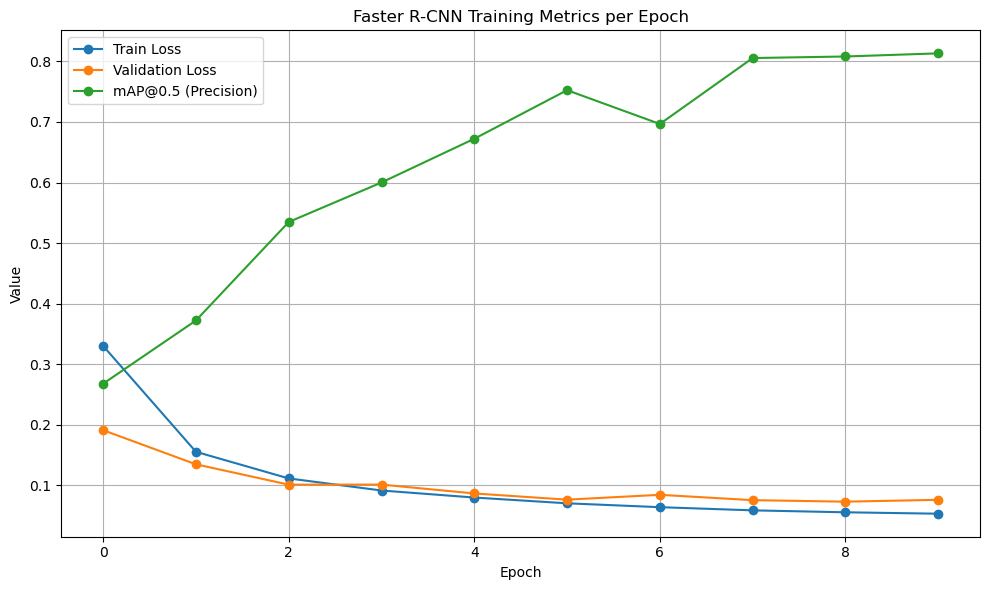

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.plot(epoch_map50, label="mAP@0.5 (Precision)", marker='o')

plt.title("Faster R-CNN Training Metrics per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()